In [11]:
def teste_revogação():
    
    #importação das bibliotecas necessárias para análise de dados
    import pandas as pd
    import datetime
    import numpy as np
    import seaborn as sb
    import matplotlib.pyplot as plt
    import squarify
    
    #definição de pronomes a serem removidos
    pronomes = ['da', 'das', 'de', 'des', 'do', 'dos', 'di', ' ']
    
    #Importação da base de usuários ativos e inativos no sistema
    while True:
        try:
            file=input('Insira o nome do arquivo da base de ativos no sistema:')
            ativos=pd.read_excel(file+".xlsx")
            
        except FileNotFoundError:
            
            print("Arquivo não encontrado!")
            continue
            
        else:
            break

    ativos.info()
    
    #Campo qual deverá ser usado como chave de cruzamento com outra base
    field1=input('Insira o nome do campo de JOIN, da base de ativos no sistema:')
    ativos['Key']=ativos[field1]
    
    if ativos['Key'].dtype != np.number:
        ativos['Key']=ativos['Key'].str.lower()
        ativos['Key']=ativos['Key'].replace(pronomes,'', regex=True)
        lastLogon=input('Insira o nome do campo de último acesso no sistema (Last Logon):')
        ativos['lastLogon']=ativos[lastLogon]
        ativos.info()
    
    #Importação de colaboradores Desligados
    while True:
        try:
            file=input('Insira o nome do arquivo da base de Desligados na Companhia:')
            desligados=pd.read_excel(file+".xlsx")
            
        except FileNotFoundError:
            
            print("Arquivo não encontrado!")
            continue
            
        else:
            
            break
            
    desligados.info()
    field2=input('Insira o nome do campo de JOIN, da base de Desligados na Companhia:')
    desligados['Key']=desligados[field2]
    
    #Bloco que verifica se o campo é de texto e realiza ajustes para padronizar a chave
    if desligados['Key'].dtype != np.number:
        
        desligados['Key']=desligados['Key'].str.lower()
        desligados['Key']=desligados['Key'].replace(pronomes,'', regex=True)
        dataDemissao=input('Insira o nome do campo de data de demissão do colaborador:')
        desligados['dataDemissao']=desligados[dataDemissao]
        #desligados[dataDemissao] = pd.to_datetime(desligados[dataDemissao])
        
    desligados.info()
    
    #Bloco de JOIN das bases importadas
    join=pd.merge(ativos, desligados, on=['Key'])
    
    #Calculo de Days (Last Logon - Demissao)
    join['Days']=(join['lastLogon']-join['dataDemissao']).dt.days
    inconsistentes=join[join['Days']>0]
    
    #Bloco que verifica se existem registros inconsistentes e executa as devidas análises
    if len(inconsistentes)>0:
        
        total=len(inconsistentes)
        maximo=inconsistentes['Days'].max()
        print("O resultado desta análise é um total " + str(total)+" de contas de usuários pertencentes a colaboradores desligados e que acessaram ao sistema em data posterior ao desligamento. Válido ressaltar que este resultado representa risco crítico de acessos indevidos terem sido materializados. O máximo de dias que uma conta obteve acesso foi de: "+str(maximo)+" Dias. O resultado desta análise foi gerado no diretório da aplicação.")
        
        #1.Plot do Treemap
        df_treemap = inconsistentes.groupby('DEPARTAMENTO').size().reset_index(name='counts')
        labels = df_treemap.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
        sizes = df_treemap['counts'].values.tolist()
        colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]
        #1.1.Desenho Gráfico
        plt.figure(figsize=(20,10), dpi= 80)
        squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8, text_kwargs={'fontsize':10}, pad=True)
        #1.2.Definições
        plt.title('Acessos divergentes por Departamento')
        plt.axis('off')
        plt.show()

        #1.Lollipop Chart
        df_lollipop=inconsistentes[['DEPARTAMENTO', 'Days']].groupby('DEPARTAMENTO').apply(lambda x: x.mean())
        df_lollipop.sort_values('Days', inplace=True)
        df_lollipop.reset_index(inplace=True)
        #1.1.Desenho
        fig, ax = plt.subplots(figsize=(10,12), dpi= 80)
        ax.vlines(x=df_lollipop.index, ymin=0, ymax=df_lollipop.Days, color='firebrick', alpha=0.7, linewidth=2)
        ax.scatter(x=df_lollipop.index, y=df_lollipop.Days, s=75, color='firebrick', alpha=0.7)
        #1.2.Titulo, labels e etc..
        ax.set_title('Diferença média de dias que as contas acessaram ao sistema após o desligamento do colaborador responsável.', fontdict={'size':22})
        ax.set_ylabel('Diferença em dias: Dt. de último acesso ao sistema e Dt. de desligamento')
        ax.set_xticks(df_lollipop.index)
        ax.set_xticklabels(df_lollipop.DEPARTAMENTO.str.upper(), rotation=60, fontdict={'horizontalalignment': 'right', 'size':12})
        ax.set_ylim(0, 250)
        # Iteração no Index
        for row in df_lollipop.itertuples():

            ax.text(row.Index, row.Days+.5, s=round(row.Days, 2), horizontalalignment= 'center', verticalalignment='bottom', fontsize=14)

        plt.show()


        inconsistentes.to_excel('Resultado_Revogados_v01.xlsx')
        inconsistentes.info()
    
    else:
            
                print("O Cruzamento de bases através da chave fornecida não possui registros em comum. Tente executar este script novamente com outra chave de cruzamento.")

        

Insira o nome do arquivo da base de ativos no sistema:Usuarios_Ativos
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 482 entries, 0 to 481
Data columns (total 6 columns):
Login              478 non-null object
Nome do Usuario    482 non-null object
Perfil Acesso      478 non-null object
Ultimo Logon       478 non-null datetime64[ns]
Data Criação       478 non-null object
Status             474 non-null object
dtypes: datetime64[ns](1), object(5)
memory usage: 22.7+ KB
Insira o nome do campo de JOIN, da base de ativos no sistema:Nome do Usuario
Insira o nome do campo de último acesso no sistema (Last Logon):Ultimo Logon
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 482 entries, 0 to 481
Data columns (total 8 columns):
Login              478 non-null object
Nome do Usuario    482 non-null object
Perfil Acesso      478 non-null object
Ultimo Logon       478 non-null datetime64[ns]
Data Criação       478 non-null object
Status             474 non-null object
Key                482 n

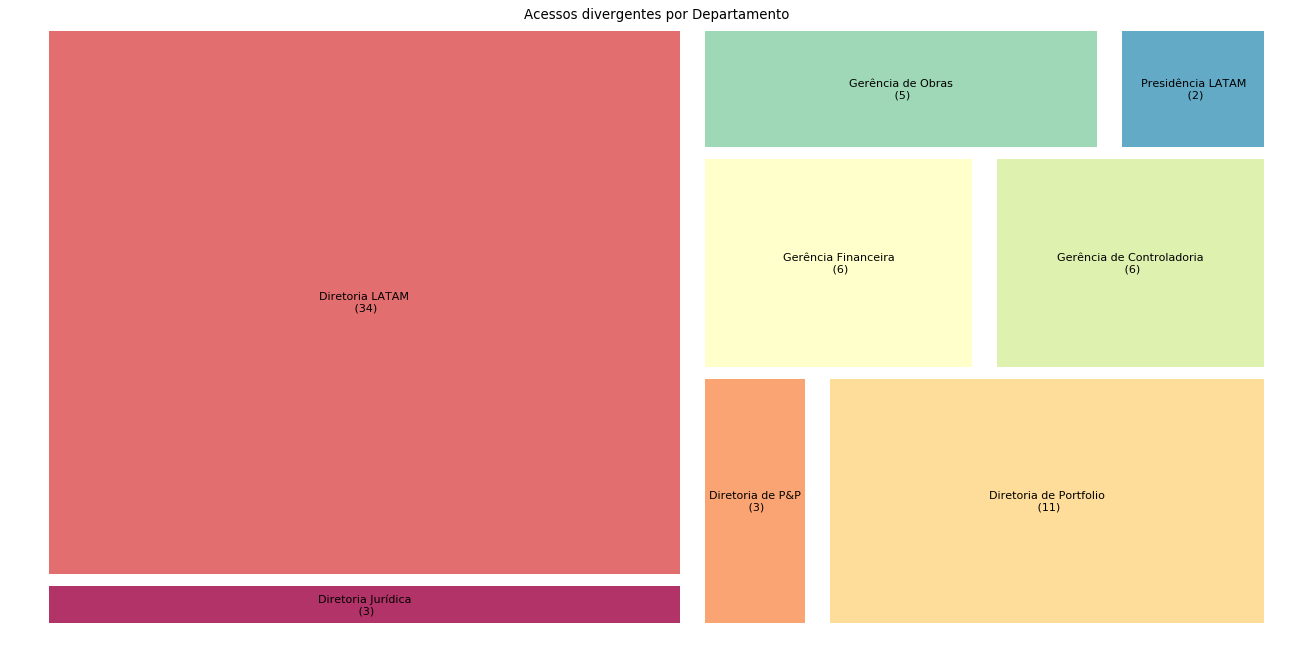

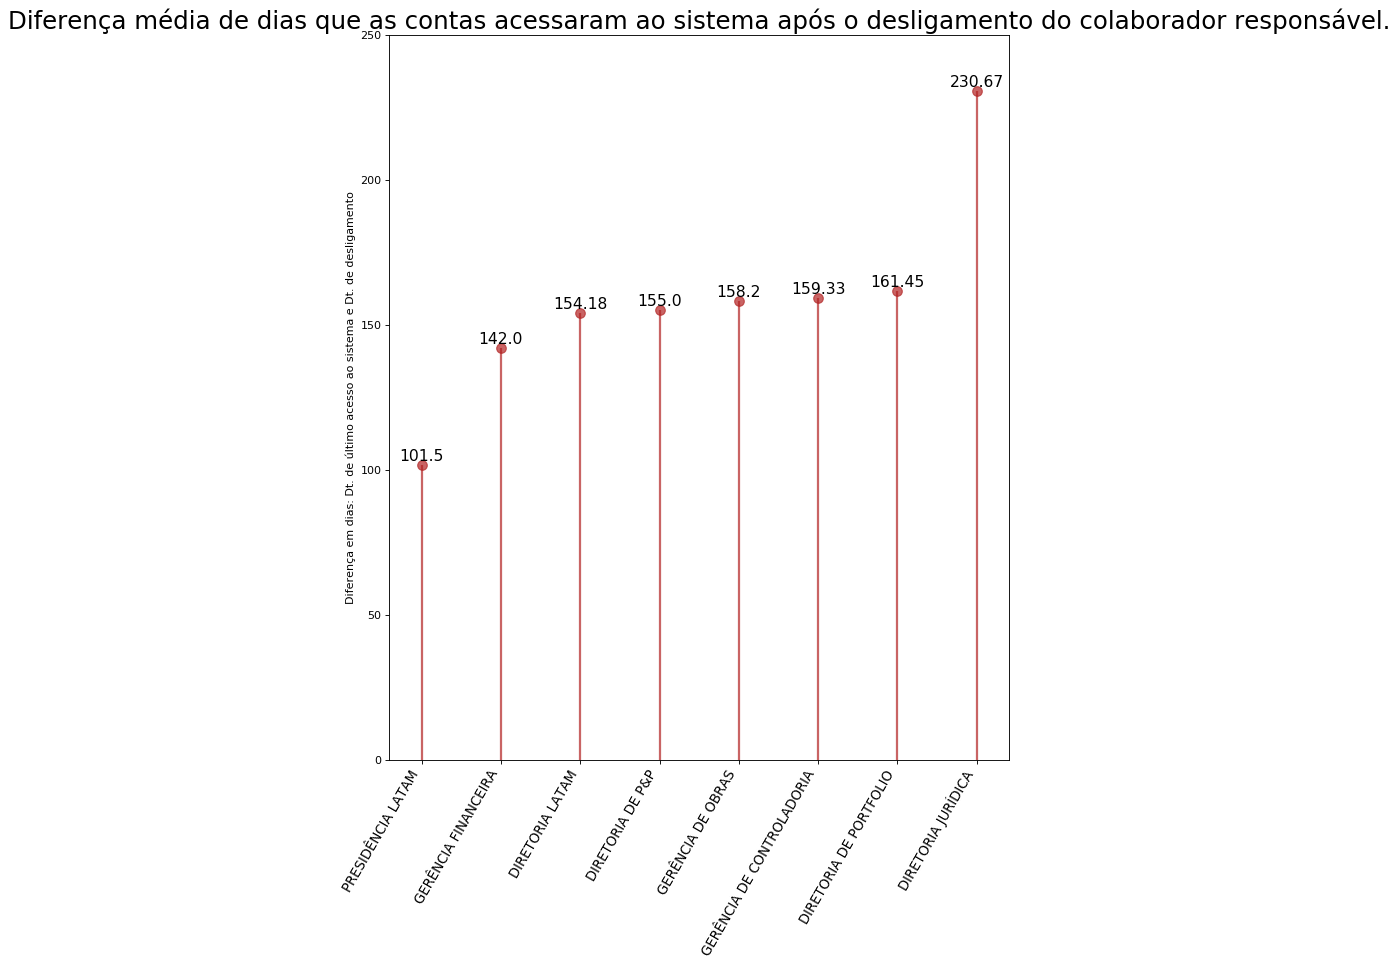

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70 entries, 18 to 95
Data columns (total 18 columns):
Login              70 non-null object
Nome do Usuario    70 non-null object
Perfil Acesso      70 non-null object
Ultimo Logon       70 non-null datetime64[ns]
Data Criação       70 non-null object
Status             70 non-null object
Key                70 non-null object
lastLogon          70 non-null datetime64[ns]
Desligamento       70 non-null datetime64[ns]
MATRÍCULA          70 non-null int64
NOME               70 non-null object
FUNÇÃO             70 non-null object
SEÇÃO              70 non-null object
DEPARTAMENTO       70 non-null object
LOCAL              70 non-null object
CODUSUARIO         70 non-null object
dataDemissao       70 non-null datetime64[ns]
Days               70 non-null int64
dtypes: datetime64[ns](4), int64(2), object(12)
memory usage: 10.4+ KB


In [12]:
teste_revogação()